In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/DL_project')
# --- 유저가 제공한 코드 ---
GDRIVE_BASE_PATH = "/content/drive/MyDrive/DL_project"
LOCAL_BASE_PATH = "/content/local_ocr_data"
os.makedirs(LOCAL_BASE_PATH, exist_ok=True)

print("Google Drive에서 zip 파일 복사를 시작합니다...")
!cp  {GDRIVE_BASE_PATH}/zips/train_labels.zip {LOCAL_BASE_PATH}/
!cp  {GDRIVE_BASE_PATH}/zips/test_labels.zip {LOCAL_BASE_PATH}/
!cp  {GDRIVE_BASE_PATH}/zips/test_images.zip {LOCAL_BASE_PATH}/
!cp  {GDRIVE_BASE_PATH}/zips/train_images.zip {LOCAL_BASE_PATH}/
!cp  {GDRIVE_BASE_PATH}/vocab.json {LOCAL_BASE_PATH}/
print("zip 파일 복사 완료.")

# --- 여기부터 압축 해제 로직 ---
print("\n로컬 디스크에서 압축 해제를 시작합니다...")

# 1. 압축 파일 경로 정의
train_lbl_zip = os.path.join(LOCAL_BASE_PATH, "train_labels.zip")
test_lbl_zip = os.path.join(LOCAL_BASE_PATH, "test_labels.zip")
train_img_zip = os.path.join(LOCAL_BASE_PATH, "train_images.zip")
test_img_zip = os.path.join(LOCAL_BASE_PATH, "test_images.zip")

# 2. 압축을 풀 대상 폴더 경로 정의
train_lbl_dir = os.path.join(LOCAL_BASE_PATH, "train_labels")
test_lbl_dir = LOCAL_BASE_PATH
train_img_dir = LOCAL_BASE_PATH
test_img_dir = LOCAL_BASE_PATH

!mkdir -p {train_lbl_dir}

# 4. !unzip 명령어로 압축 해제
# -q 옵션: 파일 목록이 터미널에 출력되는 것을 생략 (로그를 깔끔하게 유지)
# -d 옵션: 압축을 풀 대상 디렉토리(폴더)를 지정
print("train_labels.zip 압축 해제 중...")
!unzip -q {train_lbl_zip} -d {train_lbl_dir}

print("test_labels.zip 압축 해제 중...")
!unzip -q {test_lbl_zip} -d {test_lbl_dir}
!rm {train_lbl_zip}
!rm {test_lbl_zip}

print("test_images.zip 압축 해제 중...")
!unzip -q {test_img_zip} -d {test_img_dir}
!rm {test_img_zip}

print("train_images.zip 압축 해제 중...")
!unzip -q {train_img_zip} -d {train_img_dir}
!rm {train_img_zip}

print("\n✅ 모든 파일 압축 해제 완료!")


Mounted at /content/drive
Google Drive에서 zip 파일 복사를 시작합니다...
zip 파일 복사 완료.

로컬 디스크에서 압축 해제를 시작합니다...
train_labels.zip 압축 해제 중...
test_labels.zip 압축 해제 중...
test_images.zip 압축 해제 중...
train_images.zip 압축 해제 중...

✅ 모든 파일 압축 해제 완료!


In [ ]:
import os
import json
import sys
from typing import List
from pydantic import BaseModel, ValidationError
import multiprocessing as mp
import time

# Google Drive 마운트 및 경로 설정 (기존과 동일)
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    sys.path.append('/content/drive/MyDrive/DL_project/common')
    sys.path.append('/content/drive/MyDrive/DL_project/dataset')
    BASE_GDRIVE_PATH = "/content/drive/MyDrive/DL_project"
except ImportError:
    print("Google Colab 환경이 아닙니다. 경로를 직접 설정해주세요.")
    BASE_GDRIVE_PATH = "YOUR_PROJECT_PATH"
    sys.path.append(BASE_GDRIVE_PATH)
    sys.path.append(os.path.join(BASE_GDRIVE_PATH, "dataset"))

# --- Pydantic 모델 정의 (기존과 동일) ---
class Annotation(BaseModel):
    object_recognition: int
    text_language: int
# ... (Dataset, Images, BBox, Label 클래스 정의는 기존과 동일) ...
class Dataset(BaseModel):
    category: int
    identifier: str
    label_path: str
    name: str
    src_path: str
    type: int

class Images(BaseModel):
    acquistion_location: str
    application_field: str
    background: int
    data_captured: str
    height: int
    identifier: str
    media_type: int
    pen_color: str
    pen_type: int
    type: str
    width: int
    writer_age: int
    writer_sex: int
    written_content: int

class BBox(BaseModel):
    data: str
    id: int
    x: List[int]
    y: List[int]

class Label(BaseModel):
    Annotation: Annotation
    Dataset: Dataset
    Images: Images
    bbox: List[BBox]
# -----------------------------------------------------------

# --- 실제 최대 길이 찾는 함수 (수정됨) ---
def find_max_len_in_file(label_path):
    """단일 JSON 파일에서 가장 긴 bbox.data 길이와 해당 텍스트를 찾습니다."""
    max_len = 0
    max_len_text = "" # ✨ 가장 긴 텍스트를 저장할 변수 추가
    try:
        with open(label_path, 'r', encoding='utf-8') as f:
            label_data = json.load(f)
            label = Label(**label_data)
            for bbox in label.bbox:
                current_len = len(bbox.data)
                if current_len > max_len:
                    max_len = current_len
                    max_len_text = bbox.data # ✨ 텍스트 업데이트
    except (FileNotFoundError, ValidationError, json.JSONDecodeError) as e:
        pass
    # ✨ 길이, 텍스트, 파일 경로를 튜플로 반환
    return (max_len, max_len_text, label_path)

def find_overall_max_length(label_dir):
    """주어진 디렉토리의 모든 JSON 라벨 파일에서 최대 길이, 해당 텍스트, 파일 경로를 찾습니다."""
    if not os.path.isdir(label_dir):
        print(f"오류: '{label_dir}'는 유효한 디렉토리가 아닙니다.")
        return (0, "", "")

    label_files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.json')]

    if not label_files:
        print(f"오류: '{label_dir}' 디렉토리에서 JSON 파일을 찾을 수 없습니다.")
        return (0, "", "")

    print(f"총 {len(label_files)}개의 라벨 파일 분석 시작...")

    num_processes = mp.cpu_count()
    print(f"{num_processes}개의 프로세스를 사용하여 병렬 처리합니다.")

    overall_max_len = 0
    overall_max_text = ""
    source_file = ""

    with mp.Pool(processes=num_processes) as pool:
        # pool.map은 각 파일에 대한 (길이, 텍스트, 경로) 튜플 리스트를 반환
        results = pool.map(find_max_len_in_file, label_files)

    # ✨ 결과 리스트를 순회하며 전체 최대값 찾기
    for length, text, file_path in results:
        if length > overall_max_len:
            overall_max_len = length
            overall_max_text = text
            source_file = file_path # 파일 경로 업데이트

    return (overall_max_len, overall_max_text, source_file)

# --- 실행 부분 (수정됨) ---
if __name__ == "__main__":
    TRAIN_LBL_PATH = "/content/local_ocr_data/train_labels" # 로컬 경로 예시

    start_time = time.time()
    # ✨ 반환값으로 길이, 텍스트, 파일 경로를 모두 받음
    max_label_length, max_text, file_path = find_overall_max_length(TRAIN_LBL_PATH)
    end_time = time.time()

    if max_label_length > 0:
        print("\n--- 결과 ---")
        print(f"훈련 데이터셋에서 가장 긴 텍스트 라벨의 길이는: {max_label_length}")
        # ✨ 가장 긴 텍스트 내용 출력
        print(f"가장 긴 텍스트 내용: '{max_text}'")
        # ✨ 해당 텍스트가 발견된 파일 경로 출력
        print(f"해당 텍스트가 발견된 파일: {file_path}")
        print(f"분석에 걸린 시간: {end_time - start_time:.2f} 초")

        # CURRENT_MAX_LEN = 25
        # if max_label_length > CURRENT_MAX_LEN:
        #     print(f"⚠️ 경고: 현재 설정된 MAX_LABEL_LEN ({CURRENT_MAX_LEN})보다 긴 라벨이 있습니다.")
        # else:
        #     print(f"✅ 현재 설정된 MAX_LABEL_LEN ({CURRENT_MAX_LEN})은 충분합니다.")

Mounted at /content/drive
총 31535개의 라벨 파일 분석 시작...
8개의 프로세스를 사용하여 병렬 처리합니다.

--- 결과 ---
훈련 데이터셋에서 가장 긴 텍스트 라벨의 길이는: 16
가장 긴 텍스트 내용: 'Alberthirschaman'
해당 텍스트가 발견된 파일: /content/local_ocr_data/train_labels/IMG_OCR_53_4PR_53832.json
분석에 걸린 시간: 1.60 초


Mounted at /content/drive
데이터 로딩 중...
🚀 OCR 데이터셋 초기화를 시작합니다...
✅ 단어장 로드 완료. 총 글자 수: 4109
✅ 총 31535개의 이미지 파일을 처리 대상으로 설정했습니다.
🚀 OCR 데이터셋 초기화를 시작합니다...
✅ 단어장 로드 완료. 총 글자 수: 4109
✅ 총 4000개의 이미지 파일을 처리 대상으로 설정했습니다.
사용 가능한 CPU 코어 수: 8, 8개의 생산자 프로세스를 사용합니다.

🚀 글자 수 예측 모델 학습을 시작합니다 (로컬 디스크 I/O + 멀티프로세싱)...
Iter: 20 / 5000 | Loss: 2.2811 | 데이터 로딩+전송: 0.093초 | 학습 연산: 0.215초
Iter: 40 / 5000 | Loss: 1.6115 | 데이터 로딩+전송: 0.035초 | 학습 연산: 0.201초
Iter: 60 / 5000 | Loss: 1.2876 | 데이터 로딩+전송: 0.034초 | 학습 연산: 0.202초
Iter: 80 / 5000 | Loss: 1.0232 | 데이터 로딩+전송: 0.033초 | 학습 연산: 0.203초
Iter: 100 / 5000 | Loss: 0.9024 | 데이터 로딩+전송: 0.033초 | 학습 연산: 0.204초
Iter: 120 / 5000 | Loss: 0.7634 | 데이터 로딩+전송: 0.034초 | 학습 연산: 0.203초
========== EPOCH 1 ==========
Train Acc: 0.6700 | Test Acc: 0.7200
Iter: 140 / 5000 | Loss: 1.0413 | 데이터 로딩+전송: 0.038초 | 학습 연산: 0.201초
Iter: 160 / 5000 | Loss: 0.6453 | 데이터 로딩+전송: 0.041초 | 학습 연산: 0.200초
Iter: 180 / 5000 | Loss: 0.6683 | 데이터 로딩+전송: 0.043초 | 학습 연산: 0.200초
Iter: 200 / 5000 | Loss:

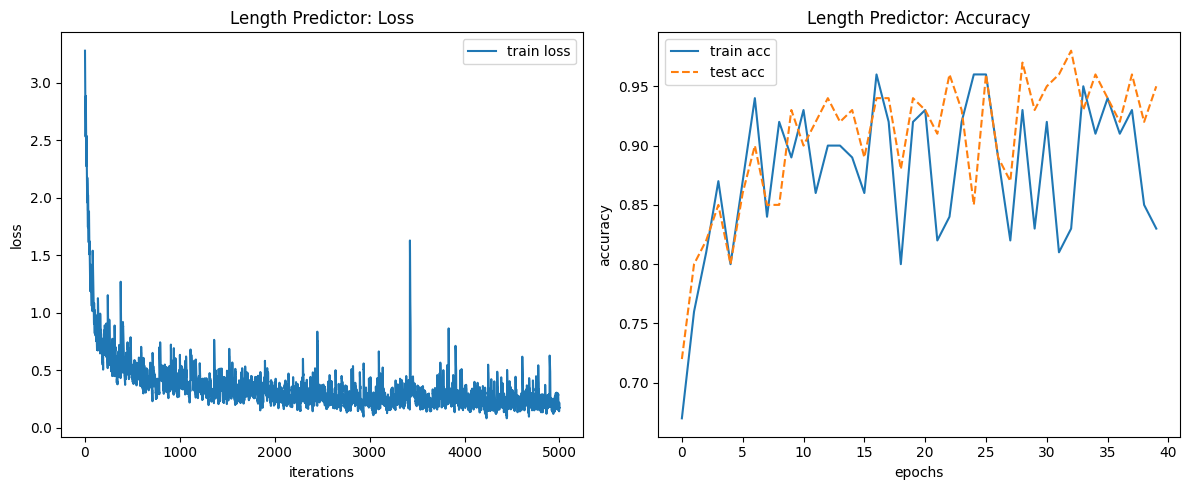

In [ ]:
# ✨✨✨ 이 부분만 수정 ✨✨✨
import os
import sys
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import pickle
import time
from google.colab import drive

import multiprocessing as mp

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/DL_project')

from dataset.ocr_dataset import OCRDataset
from cu_length_predictor_net_bn import LengthPredictorNetBN
from common.cu_optimizer import Adam

# 데이터 생산자 함수 (기존과 동일)
def data_producer(dataset, queue, batch_size):
    while True:
        x_batch, t_batch = dataset.get_batch(batch_size)
        if x_batch.shape[0] > 0:
            queue.put((x_batch, t_batch))

# 헬퍼 함수 (기존과 동일)
def convert_to_length_labels(text_labels, max_len, pad_id=0):
    length_labels = []
    for label in cp.asnumpy(text_labels):
        true_len_idx = np.where(label == pad_id)[0]
        if len(true_len_idx) > 0:
            length = true_len_idx[0]
            if length == 0: length = 1
            length_labels.append(length - 1)
        else:
            length_labels.append(max_len - 1)
    return cp.array(length_labels, dtype=cp.int32)

# 1. 데이터 로드 및 파라머터 설정
print("데이터 로딩 중...")

# ✨✨✨ [변경점] 기본 경로를 코랩 로컬 경로로 수정 ✨✨✨
BASE_PATH = "/content/local_ocr_data" # 구글 드라이브 대신 로컬 경로 사용
GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/DL_project" # 파라미터 저장용

TRAIN_IMG_PATH = os.path.join(BASE_PATH, "train_images/train_images")
TRAIN_LBL_PATH = os.path.join(BASE_PATH, "train_labels")
TEST_IMG_PATH = os.path.join(BASE_PATH, "test_images/test_images")
TEST_LBL_PATH = os.path.join(BASE_PATH, "test_labels")
VOCAB_PATH = os.path.join(BASE_PATH, "vocab.json")

IMAGE_WIDTH, IMAGE_HEIGHT = 256, 64
MAX_LABEL_LEN = 25
PAD_ID = 0

# 데이터셋 객체 생성 시 이제 빠른 로컬 경로를 사용합니다.
train_dataset = OCRDataset(TRAIN_IMG_PATH, TRAIN_LBL_PATH, VOCAB_PATH, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), max_label_len=MAX_LABEL_LEN)
test_dataset = OCRDataset(TEST_IMG_PATH, TEST_LBL_PATH, VOCAB_PATH, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), max_label_len=MAX_LABEL_LEN)

# (이하 모든 코드는 원래 코드와 완전히 동일합니다)

# 2. 모델, 옵티마이저 생성
network = LengthPredictorNetBN(input_dim=(1, IMAGE_HEIGHT, IMAGE_WIDTH),
                               max_output_len=MAX_LABEL_LEN)
optimizer = Adam(lr=0.001)

# 3. 학습 하이퍼파라미터 설정
iters_num = 5000
batch_size = 256
train_size = len(train_dataset.image_files)
iter_per_epoch = max(train_size // batch_size, 1)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 멀티프로세싱 설정
NUM_PRODUCERS = mp.cpu_count()
print(f"사용 가능한 CPU 코어 수: {NUM_PRODUCERS}, {NUM_PRODUCERS}개의 생산자 프로세스를 사용합니다.")
data_queue = mp.Queue(maxsize=NUM_PRODUCERS * 5)
producers = []
for _ in range(NUM_PRODUCERS):
    p = mp.Process(target=data_producer,
                   args=(train_dataset, data_queue, batch_size),
                   daemon=True)
    p.start()
    producers.append(p)

data_time = 0
compute_time = 0

print("\n🚀 글자 수 예측 모델 학습을 시작합니다 (로컬 디스크 I/O + 멀티프로세싱)...")
for i in range(iters_num):
    start_data = time.time()
    x_batch_np, t_text_batch_np = data_queue.get()
    x_batch = cp.asarray(x_batch_np)
    t_text_batch = cp.asarray(t_text_batch_np)
    data_time += time.time() - start_data

    t_len_batch = convert_to_length_labels(t_text_batch, MAX_LABEL_LEN, PAD_ID)

    start_compute = time.time()
    grad = network.gradient(x_batch, t_len_batch)
    optimizer.update(network.params, grad)
    compute_time += time.time() - start_compute

    loss = network.loss(x_batch, t_len_batch)
    train_loss_list.append(cp.asnumpy(loss))

    if (i + 1) % 20 == 0:
        avg_data_time = data_time / 20
        avg_compute_time = compute_time / 20
        print(f"Iter: {i+1} / {iters_num} | Loss: {loss.get():.4f} | "
              f"데이터 로딩+전송: {avg_data_time:.3f}초 | 학습 연산: {avg_compute_time:.3f}초")
        data_time, compute_time = 0, 0

    if (i + 1) % iter_per_epoch == 0:
        epoch_num = (i + 1) // iter_per_epoch

        x_train_sample_np, t_train_text_sample_np = train_dataset.get_batch(100)
        x_train_sample = cp.asarray(x_train_sample_np)
        t_train_text_sample = cp.asarray(t_train_text_sample_np)
        t_train_len_sample = convert_to_length_labels(t_train_text_sample, MAX_LABEL_LEN, PAD_ID)
        train_acc = network.accuracy(x_train_sample, t_train_len_sample)
        train_acc_list.append(cp.asnumpy(train_acc))

        x_test_sample_np, t_test_text_sample_np = test_dataset.get_batch(100)
        x_test_sample = cp.asarray(x_test_sample_np)
        t_test_text_sample = cp.asarray(t_test_text_sample_np)
        t_test_len_sample = convert_to_length_labels(t_test_text_sample, MAX_LABEL_LEN, PAD_ID)
        test_acc = network.accuracy(x_test_sample, t_test_len_sample)
        test_acc_list.append(cp.asnumpy(test_acc))

        print(f"========== EPOCH {int(epoch_num)} ==========")
        print(f"Train Acc: {train_acc.get():.4f} | Test Acc: {test_acc.get():.4f}")
        print("==============================")

for p in producers:
    p.terminate()

# 4. 파라미터 저장 (저장은 다시 구글 드라이브에 합니다)
params_file = os.path.join(GDRIVE_PROJECT_PATH, "length_predictor_params_cupy_local.pkl")
params_cpu = {}
for key, val in network.params.items():
    params_cpu[key] = cp.asnumpy(val)
with open(params_file, 'wb') as f:
    pickle.dump(params_cpu, f)
print(f"\n✅ 학습된 파라미터를 '{params_file}'에 저장했습니다.")

# 5. 그래프 그리기 (기존과 동일)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train loss')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("Length Predictor: Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Length Predictor: Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Mounted at /content/drive
데이터 로딩 중...
🚀 OCR 데이터셋 초기화를 시작합니다...
✅ 단어장 로드 완료. 총 글자 수: 4109
✅ 총 31535개의 이미지 파일을 처리 대상으로 설정했습니다.
🚀 OCR 데이터셋 초기화를 시작합니다...
✅ 단어장 로드 완료. 총 글자 수: 4109
✅ 총 4000개의 이미지 파일을 처리 대상으로 설정했습니다.
4개의 생산자 프로세스를 사용합니다.

🚀 OCR 모델 학습을 시작합니다 (TSWL + BN, 로컬 I/O)...
Iter: 20 / 5000 | Loss: 14.4123 | 데이터 로딩+전송: 0.062초 | 학습 연산: 0.356초
Iter: 40 / 5000 | Loss: 13.9742 | 데이터 로딩+전송: 0.024초 | 학습 연산: 0.351초
Iter: 60 / 5000 | Loss: 16.0823 | 데이터 로딩+전송: 0.024초 | 학습 연산: 0.353초
Iter: 80 / 5000 | Loss: 12.2190 | 데이터 로딩+전송: 0.023초 | 학습 연산: 0.349초
Iter: 100 / 5000 | Loss: 12.8989 | 데이터 로딩+전송: 0.023초 | 학습 연산: 0.347초
Iter: 120 / 5000 | Loss: 15.2557 | 데이터 로딩+전송: 0.023초 | 학습 연산: 0.346초
========== EPOCH 1 ==========
Train Acc: 0.0600 | Test Acc: 0.0000
Iter: 140 / 5000 | Loss: 11.4880 | 데이터 로딩+전송: 0.026초 | 학습 연산: 0.345초
Iter: 160 / 5000 | Loss: 11.1927 | 데이터 로딩+전송: 0.026초 | 학습 연산: 0.347초
Iter: 180 / 5000 | Loss: 10.4186 | 데이터 로딩+전송: 0.026초 | 학습 연산: 0.348초
Iter: 200 / 5000 | Loss: 13.2866 | 데이터 로딩

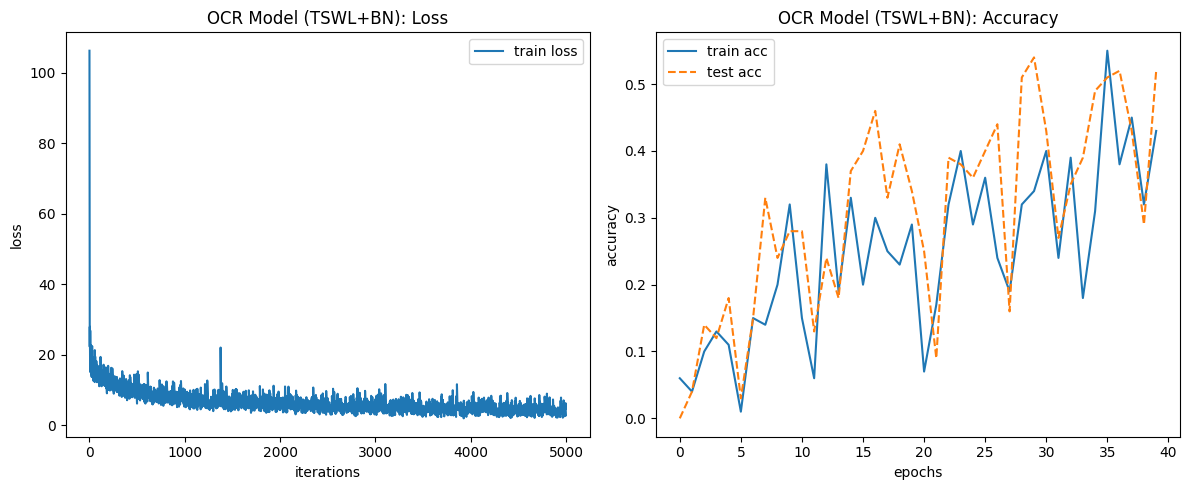

In [ ]:
import os
import sys
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import pickle
import time
from google.colab import drive

import multiprocessing as mp

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/DL_project')

from dataset.ocr_dataset import OCRDataset
from cu_ocr_net_bn import OcrNetBN # ✨ TSWL용 BN 모델 임포트
from common.cu_optimizer import Adam

# 데이터 생산자 함수 (기존과 동일)
def data_producer(dataset, queue, batch_size):
    while True:
        x_batch, t_batch = dataset.get_batch(batch_size)
        if x_batch.shape[0] > 0:
            queue.put((x_batch, t_batch))

# ✨ convert_to_length_labels 함수 제거

# 1. 데이터 로드 및 파라미터 설정
print("데이터 로딩 중...")
BASE_PATH = "/content/local_ocr_data"
GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/DL_project"

TRAIN_IMG_PATH = os.path.join(BASE_PATH, "train_images")
TRAIN_LBL_PATH = os.path.join(BASE_PATH, "train_labels")
TEST_IMG_PATH = os.path.join(BASE_PATH, "test_images")
TEST_LBL_PATH = os.path.join(BASE_PATH, "test_labels")
VOCAB_PATH = os.path.join(BASE_PATH, "vocab.json")

IMAGE_WIDTH, IMAGE_HEIGHT = 256, 64
MAX_LABEL_LEN = 16
PAD_ID = 0 # accuracy 계산 시 필요

train_dataset = OCRDataset(TRAIN_IMG_PATH, TRAIN_LBL_PATH, VOCAB_PATH, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), max_label_len=MAX_LABEL_LEN)
test_dataset = OCRDataset(TEST_IMG_PATH, TEST_LBL_PATH, VOCAB_PATH, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), max_label_len=MAX_LABEL_LEN)

# 2. 모델, 옵티마이저 생성
network = OcrNetBN(input_dim=(1, IMAGE_HEIGHT, IMAGE_WIDTH),
                   max_label_len=MAX_LABEL_LEN,
                   vocab_size=train_dataset.vocab_size)
optimizer = Adam(lr=0.01)

# 3. 학습 하이퍼파라미터 설정
iters_num = 5000
batch_size = 256 # ✨ 배치 크기 원복 (GPU 메모리 확인 필요)
train_size = len(train_dataset.image_files)
iter_per_epoch = max(train_size // batch_size, 1)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 멀티프로세싱 설정
NUM_PRODUCERS = 4 # mp.cpu_count() # ✨ 안정성을 위해 4로 시작 권장
print(f"{NUM_PRODUCERS}개의 생산자 프로세스를 사용합니다.")
data_queue = mp.Queue(maxsize=NUM_PRODUCERS * 5)
producers = []
for _ in range(NUM_PRODUCERS):
    p = mp.Process(target=data_producer,
                   args=(train_dataset, data_queue, batch_size),
                   daemon=True)
    p.start()
    producers.append(p)

data_time = 0
compute_time = 0

print("\n🚀 OCR 모델 학습을 시작합니다 (TSWL + BN, 로컬 I/O)...")
for i in range(iters_num):
    start_data = time.time()
    x_batch_np, t_text_batch_np = data_queue.get()
    x_batch = cp.asarray(x_batch_np)
    t_text_batch = cp.asarray(t_text_batch_np) # ✨ 글자 내용 레이블 사용!
    data_time += time.time() - start_data

    # ✨ t_len_batch 변환 로직 제거

    start_compute = time.time()
    grad = network.gradient(x_batch, t_text_batch) # ✨ t_text_batch 전달
    optimizer.update(network.params, grad)
    compute_time += time.time() - start_compute

    loss = network.loss(x_batch, t_text_batch) # ✨ t_text_batch 전달
    train_loss_list.append(cp.asnumpy(loss))

    if (i + 1) % 20 == 0:
        avg_data_time = data_time / 20
        avg_compute_time = compute_time / 20
        print(f"Iter: {i+1} / {iters_num} | Loss: {loss.get():.4f} | "
              f"데이터 로딩+전송: {avg_data_time:.3f}초 | 학습 연산: {avg_compute_time:.3f}초")
        data_time, compute_time = 0, 0

    if (i + 1) % iter_per_epoch == 0:
        epoch_num = (i + 1) // iter_per_epoch

        # Train 정확도
        x_train_sample_np, t_train_text_sample_np = train_dataset.get_batch(100)
        x_train_sample = cp.asarray(x_train_sample_np)
        t_train_text_sample = cp.asarray(t_train_text_sample_np)
        # ✨ t_len_sample 변환 제거
        train_acc = network.accuracy(x_train_sample, t_train_text_sample, pad_id=PAD_ID) # ✨ t_text_sample 전달
        train_acc_list.append(cp.asnumpy(train_acc))

        # Test 정확도
        x_test_sample_np, t_test_text_sample_np = test_dataset.get_batch(100)
        x_test_sample = cp.asarray(x_test_sample_np)
        t_test_text_sample = cp.asarray(t_test_text_sample_np)
        # ✨ t_len_sample 변환 제거
        test_acc = network.accuracy(x_test_sample, t_test_text_sample, pad_id=PAD_ID) # ✨ t_text_sample 전달
        test_acc_list.append(cp.asnumpy(test_acc))

        print(f"========== EPOCH {int(epoch_num)} ==========")
        print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
        print("==============================")

for p in producers:
    p.terminate()

# 4. 파라미터 저장
params_file = os.path.join(GDRIVE_PROJECT_PATH, "ocr_params_bn_cupy_local.pkl") # ✨ 파일명 변경
params_cpu = {}
for key, val in network.params.items():
    params_cpu[key] = cp.asnumpy(val)
with open(params_file, 'wb') as f:
    pickle.dump(params_cpu, f)
print(f"\n✅ 학습된 파라미터를 '{params_file}'에 저장했습니다.")

# 5. 그래프 그리기
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train loss')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("OCR Model (TSWL+BN): Loss") # ✨ 제목 변경
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("OCR Model (TSWL+BN): Accuracy") # ✨ 제목 변경
plt.legend()

plt.tight_layout()
plt.show()

Mounted at /content/drive
데이터 로딩 중...
🚀 OCR 데이터셋 초기화를 시작합니다...
✅ 단어장 로드 완료. 총 글자 수: 4109
✅ 총 31535개의 이미지 파일을 처리 대상으로 설정했습니다.
🚀 OCR 데이터셋 초기화를 시작합니다...
✅ 단어장 로드 완료. 총 글자 수: 4109
✅ 총 4000개의 이미지 파일을 처리 대상으로 설정했습니다.
4개의 생산자 프로세스를 사용합니다.

🚀 OCR 모델 학습을 시작합니다 (TSWL + BN, 로컬 I/O)...
Iter: 20 / 5000 | Loss: 6.6036 | 데이터 로딩+전송: 0.071초 | 학습 연산: 0.747초
Iter: 40 / 5000 | Loss: 5.6190 | 데이터 로딩+전송: 0.021초 | 학습 연산: 0.200초
Iter: 60 / 5000 | Loss: 5.3030 | 데이터 로딩+전송: 0.021초 | 학습 연산: 0.200초
Iter: 80 / 5000 | Loss: 5.0448 | 데이터 로딩+전송: 0.021초 | 학습 연산: 0.200초
Iter: 100 / 5000 | Loss: 4.7976 | 데이터 로딩+전송: 0.021초 | 학습 연산: 0.200초
Iter: 120 / 5000 | Loss: 5.8024 | 데이터 로딩+전송: 0.021초 | 학습 연산: 0.200초
========== EPOCH 1 ==========
Train Acc: 0.0200 | Test Acc: 0.0400
Iter: 140 / 5000 | Loss: 4.9474 | 데이터 로딩+전송: 0.021초 | 학습 연산: 0.200초
Iter: 160 / 5000 | Loss: 4.3943 | 데이터 로딩+전송: 0.021초 | 학습 연산: 0.200초
Iter: 180 / 5000 | Loss: 4.9246 | 데이터 로딩+전송: 0.022초 | 학습 연산: 0.200초
Iter: 200 / 5000 | Loss: 4.6119 | 데이터 로딩+전송: 0.021

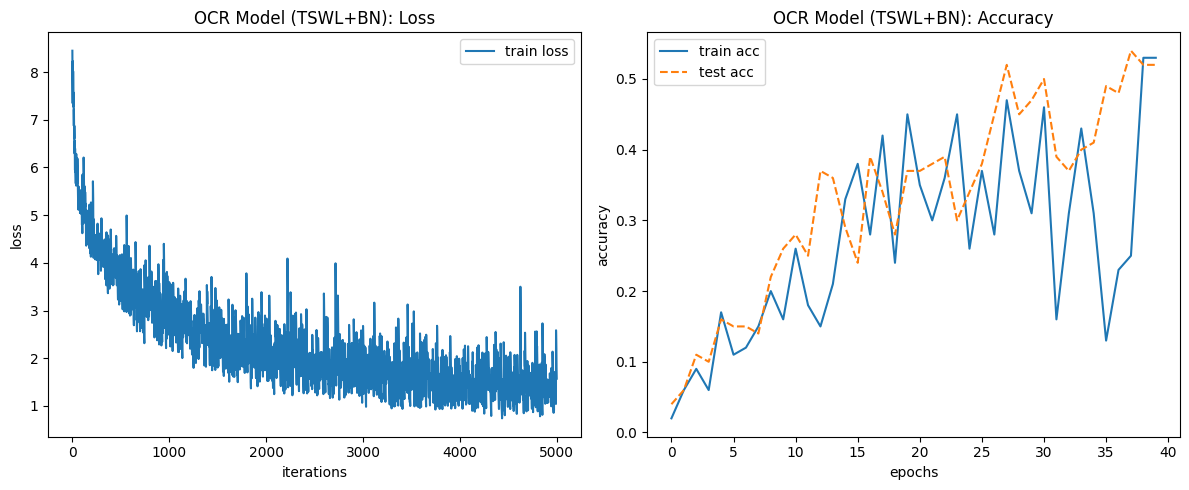

In [ ]:
import os
import sys
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import pickle
import time
from google.colab import drive

import multiprocessing as mp

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/DL_project')

from dataset.ocr_dataset import OCRDataset
from cu_ocr_net_bn2 import OcrNetBN # ✨ TSWL용 BN 모델 임포트
from common.cu_optimizer import Adam

# 데이터 생산자 함수 (기존과 동일)
def data_producer(dataset, queue, batch_size):
    while True:
        x_batch, t_batch = dataset.get_batch(batch_size)
        if x_batch.shape[0] > 0:
            queue.put((x_batch, t_batch))

# ✨ convert_to_length_labels 함수 제거

# 1. 데이터 로드 및 파라미터 설정
print("데이터 로딩 중...")
BASE_PATH = "/content/local_ocr_data"
GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/DL_project"

TRAIN_IMG_PATH = os.path.join(BASE_PATH, "train_images")
TRAIN_LBL_PATH = os.path.join(BASE_PATH, "train_labels")
TEST_IMG_PATH = os.path.join(BASE_PATH, "test_images")
TEST_LBL_PATH = os.path.join(BASE_PATH, "test_labels")
VOCAB_PATH = os.path.join(BASE_PATH, "vocab.json")

IMAGE_WIDTH, IMAGE_HEIGHT = 256, 64
MAX_LABEL_LEN = 16
PAD_ID = 0 # accuracy 계산 시 필요

train_dataset = OCRDataset(TRAIN_IMG_PATH, TRAIN_LBL_PATH, VOCAB_PATH, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), max_label_len=MAX_LABEL_LEN)
test_dataset = OCRDataset(TEST_IMG_PATH, TEST_LBL_PATH, VOCAB_PATH, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), max_label_len=MAX_LABEL_LEN)

# 2. 모델, 옵티마이저 생성
network = OcrNetBN(input_dim=(1, IMAGE_HEIGHT, IMAGE_WIDTH),
                   max_label_len=MAX_LABEL_LEN,
                   vocab_size=train_dataset.vocab_size)
optimizer = Adam(lr=0.001)

# 3. 학습 하이퍼파라미터 설정
iters_num = 5000
batch_size = 256 # ✨ 배치 크기 원복 (GPU 메모리 확인 필요)
train_size = len(train_dataset.image_files)
iter_per_epoch = max(train_size // batch_size, 1)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 멀티프로세싱 설정
NUM_PRODUCERS = 4 # mp.cpu_count() # ✨ 안정성을 위해 4로 시작 권장
print(f"{NUM_PRODUCERS}개의 생산자 프로세스를 사용합니다.")
data_queue = mp.Queue(maxsize=NUM_PRODUCERS * 5)
producers = []
for _ in range(NUM_PRODUCERS):
    p = mp.Process(target=data_producer,
                   args=(train_dataset, data_queue, batch_size),
                   daemon=True)
    p.start()
    producers.append(p)

data_time = 0
compute_time = 0

print("\n🚀 OCR 모델 학습을 시작합니다 (TSWL + BN, 로컬 I/O)...")
for i in range(iters_num):
    start_data = time.time()
    x_batch_np, t_text_batch_np = data_queue.get()
    x_batch = cp.asarray(x_batch_np)
    t_text_batch = cp.asarray(t_text_batch_np) # ✨ 글자 내용 레이블 사용!
    data_time += time.time() - start_data

    # ✨ t_len_batch 변환 로직 제거

    start_compute = time.time()
    grad = network.gradient(x_batch, t_text_batch) # ✨ t_text_batch 전달
    optimizer.update(network.params, grad)
    compute_time += time.time() - start_compute

    loss = network.loss(x_batch, t_text_batch) # ✨ t_text_batch 전달
    train_loss_list.append(cp.asnumpy(loss))

    if (i + 1) % 20 == 0:
        avg_data_time = data_time / 20
        avg_compute_time = compute_time / 20
        print(f"Iter: {i+1} / {iters_num} | Loss: {loss.get():.4f} | "
              f"데이터 로딩+전송: {avg_data_time:.3f}초 | 학습 연산: {avg_compute_time:.3f}초")
        data_time, compute_time = 0, 0

    if (i + 1) % iter_per_epoch == 0:
        epoch_num = (i + 1) // iter_per_epoch

        # Train 정확도
        x_train_sample_np, t_train_text_sample_np = train_dataset.get_batch(100)
        x_train_sample = cp.asarray(x_train_sample_np)
        t_train_text_sample = cp.asarray(t_train_text_sample_np)
        # ✨ t_len_sample 변환 제거
        train_acc = network.accuracy(x_train_sample, t_train_text_sample, pad_id=PAD_ID) # ✨ t_text_sample 전달
        train_acc_list.append(cp.asnumpy(train_acc))

        # Test 정확도
        x_test_sample_np, t_test_text_sample_np = test_dataset.get_batch(100)
        x_test_sample = cp.asarray(x_test_sample_np)
        t_test_text_sample = cp.asarray(t_test_text_sample_np)
        # ✨ t_len_sample 변환 제거
        test_acc = network.accuracy(x_test_sample, t_test_text_sample, pad_id=PAD_ID) # ✨ t_text_sample 전달
        test_acc_list.append(cp.asnumpy(test_acc))

        print(f"========== EPOCH {int(epoch_num)} ==========")
        print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
        print("==============================")

for p in producers:
    p.terminate()

# 4. 파라미터 저장
params_file = os.path.join(GDRIVE_PROJECT_PATH, "ocr_params_bn_cupy_local.pkl") # ✨ 파일명 변경
params_cpu = {}
for key, val in network.params.items():
    params_cpu[key] = cp.asnumpy(val)
with open(params_file, 'wb') as f:
    pickle.dump(params_cpu, f)
print(f"\n✅ 학습된 파라미터를 '{params_file}'에 저장했습니다.")

# 5. 그래프 그리기
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train loss')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("OCR Model (TSWL+BN): Loss") # ✨ 제목 변경
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("OCR Model (TSWL+BN): Accuracy") # ✨ 제목 변경
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import cu_ocr_net_bn2

In [ ]:
importlib.reload(cu_ocr_net_bn2)

# 만약 1단계에서 dataset.cu_ocr_net_bn 으로 임포트했다면
# importlib.reload(dataset.cu_ocr_net_bn)

<module 'cu_ocr_net_bn2' from '/content/drive/MyDrive/DL_project/cu_ocr_net_bn2.py'>

Mounted at /content/drive
데이터 로딩 중...
🚀 OCR 데이터셋 초기화를 시작합니다...
✅ 단어장 로드 완료. 총 글자 수: 4109
✅ 총 31535개의 이미지 파일을 처리 대상으로 설정했습니다.
🚀 OCR 데이터셋 초기화를 시작합니다...
✅ 단어장 로드 완료. 총 글자 수: 4109
✅ 총 4000개의 이미지 파일을 처리 대상으로 설정했습니다.
4개의 생산자 프로세스를 사용합니다.

🚀 OCR 모델 학습을 시작합니다 (TSWL + BN, 로컬 I/O)...
Iter: 20 / 5000 | Loss: 5.2419 | 데이터 로딩+전송: 0.062초 | 학습 연산: 0.486초
Iter: 40 / 5000 | Loss: 4.3189 | 데이터 로딩+전송: 0.039초 | 학습 연산: 0.486초
Iter: 60 / 5000 | Loss: 5.0232 | 데이터 로딩+전송: 0.039초 | 학습 연산: 0.485초
Iter: 80 / 5000 | Loss: 3.9676 | 데이터 로딩+전송: 0.039초 | 학습 연산: 0.484초
Iter: 100 / 5000 | Loss: 4.1245 | 데이터 로딩+전송: 0.039초 | 학습 연산: 0.484초
Iter: 120 / 5000 | Loss: 4.0998 | 데이터 로딩+전송: 0.039초 | 학습 연산: 0.485초
========== EPOCH 1 ==========
Train Acc: 0.0800 | Test Acc: 0.0200
Iter: 140 / 5000 | Loss: 3.6554 | 데이터 로딩+전송: 0.026초 | 학습 연산: 0.486초
Iter: 160 / 5000 | Loss: 3.4798 | 데이터 로딩+전송: 0.024초 | 학습 연산: 0.486초
Iter: 180 / 5000 | Loss: 3.7067 | 데이터 로딩+전송: 0.023초 | 학습 연산: 0.485초
Iter: 200 / 5000 | Loss: 3.3347 | 데이터 로딩+전송: 0.023

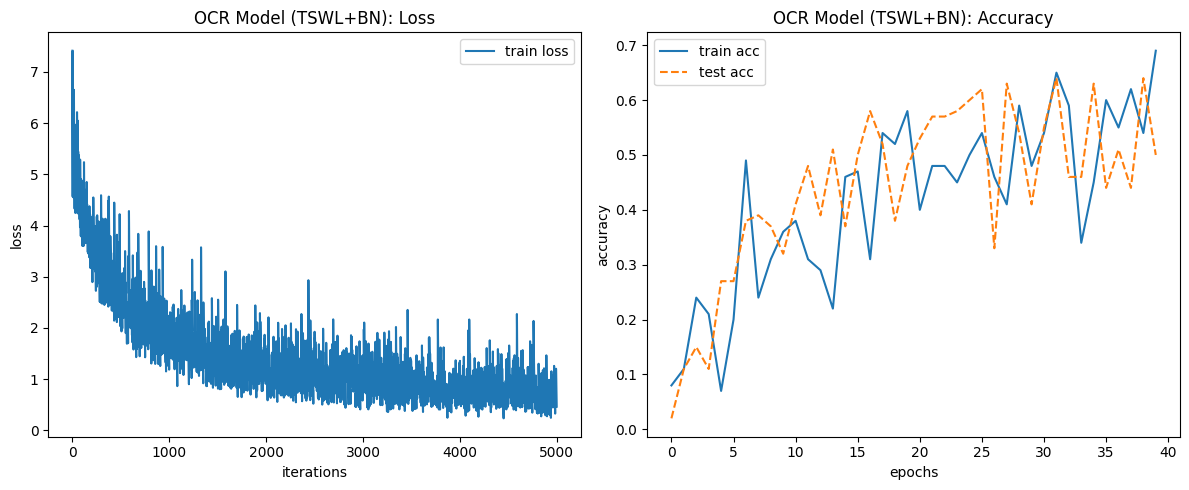

In [ ]:
import os
import sys
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import pickle
import time
from google.colab import drive

import multiprocessing as mp

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/DL_project')

from dataset.ocr_dataset import OCRDataset
from cu_ocr_net_bn2 import OcrNetBN # ✨ TSWL용 BN 모델 임포트
from common.cu_optimizer import Adam

# 데이터 생산자 함수 (기존과 동일)
def data_producer(dataset, queue, batch_size):
    while True:
        x_batch, t_batch = dataset.get_batch(batch_size)
        if x_batch.shape[0] > 0:
            queue.put((x_batch, t_batch))

# ✨ convert_to_length_labels 함수 제거

# 1. 데이터 로드 및 파라미터 설정
print("데이터 로딩 중...")
BASE_PATH = "/content/local_ocr_data"
GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/DL_project"

TRAIN_IMG_PATH = os.path.join(BASE_PATH, "train_images")
TRAIN_LBL_PATH = os.path.join(BASE_PATH, "train_labels")
TEST_IMG_PATH = os.path.join(BASE_PATH, "test_images")
TEST_LBL_PATH = os.path.join(BASE_PATH, "test_labels")
VOCAB_PATH = os.path.join(BASE_PATH, "vocab.json")

IMAGE_WIDTH, IMAGE_HEIGHT = 256, 64
MAX_LABEL_LEN = 16
PAD_ID = 0 # accuracy 계산 시 필요

train_dataset = OCRDataset(TRAIN_IMG_PATH, TRAIN_LBL_PATH, VOCAB_PATH, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), max_label_len=MAX_LABEL_LEN)
test_dataset = OCRDataset(TEST_IMG_PATH, TEST_LBL_PATH, VOCAB_PATH, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), max_label_len=MAX_LABEL_LEN)

# 2. 모델, 옵티마이저 생성
network = OcrNetBN(input_dim=(1, IMAGE_HEIGHT, IMAGE_WIDTH),
                   max_label_len=MAX_LABEL_LEN,
                   vocab_size=train_dataset.vocab_size)
optimizer = Adam(lr=0.001)
base_lr = 0.001
# 3. 학습 하이퍼파라미터 설정
iters_num = 5000
batch_size = 256 # ✨ 배치 크기 원복 (GPU 메모리 확인 필요)
train_size = len(train_dataset.image_files)
iter_per_epoch = max(train_size // batch_size, 1)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 멀티프로세싱 설정
NUM_PRODUCERS = 4 # mp.cpu_count() # ✨ 안정성을 위해 4로 시작 권장
print(f"{NUM_PRODUCERS}개의 생산자 프로세스를 사용합니다.")
data_queue = mp.Queue(maxsize=NUM_PRODUCERS * 5)
producers = []
for _ in range(NUM_PRODUCERS):
    p = mp.Process(target=data_producer,
                   args=(train_dataset, data_queue, batch_size),
                   daemon=True)
    p.start()
    producers.append(p)

data_time = 0
compute_time = 0

print("\n🚀 OCR 모델 학습을 시작합니다 (TSWL + BN, 로컬 I/O)...")
for i in range(iters_num):
    if (i > 0) and (i % 1000 == 0):
      base_lr  = base_lr * 0.5
      optimizer.lr = base_lr  # 옵티마이저의 LR을 직접 갱신
      print(f"\n✨ Iteration {i}: Learning Rate를 {new_lr:.6f}로 조정합니다. ✨\n")

    start_data = time.time()
    x_batch_np, t_text_batch_np = data_queue.get()
    x_batch = cp.asarray(x_batch_np)
    t_text_batch = cp.asarray(t_text_batch_np) # ✨ 글자 내용 레이블 사용!
    data_time += time.time() - start_data

    # ✨ t_len_batch 변환 로직 제거

    start_compute = time.time()
    grad = network.gradient(x_batch, t_text_batch) # ✨ t_text_batch 전달
    optimizer.update(network.params, grad)
    compute_time += time.time() - start_compute

    loss = network.loss(x_batch, t_text_batch) # ✨ t_text_batch 전달
    train_loss_list.append(cp.asnumpy(loss))

    if (i + 1) % 20 == 0:
        avg_data_time = data_time / 20
        avg_compute_time = compute_time / 20
        print(f"Iter: {i+1} / {iters_num} | Loss: {loss.get():.4f} | "
              f"데이터 로딩+전송: {avg_data_time:.3f}초 | 학습 연산: {avg_compute_time:.3f}초")
        data_time, compute_time = 0, 0

    if (i + 1) % iter_per_epoch == 0:
        epoch_num = (i + 1) // iter_per_epoch

        # Train 정확도
        x_train_sample_np, t_train_text_sample_np = train_dataset.get_batch(100)
        x_train_sample = cp.asarray(x_train_sample_np)
        t_train_text_sample = cp.asarray(t_train_text_sample_np)
        # ✨ t_len_sample 변환 제거
        train_acc = network.accuracy(x_train_sample, t_train_text_sample, pad_id=PAD_ID) # ✨ t_text_sample 전달
        train_acc_list.append(cp.asnumpy(train_acc))

        # Test 정확도
        x_test_sample_np, t_test_text_sample_np = test_dataset.get_batch(100)
        x_test_sample = cp.asarray(x_test_sample_np)
        t_test_text_sample = cp.asarray(t_test_text_sample_np)
        # ✨ t_len_sample 변환 제거
        test_acc = network.accuracy(x_test_sample, t_test_text_sample, pad_id=PAD_ID) # ✨ t_text_sample 전달
        test_acc_list.append(cp.asnumpy(test_acc))

        print(f"========== EPOCH {int(epoch_num)} ==========")
        print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
        print("==============================")

for p in producers:
    p.terminate()

# 4. 파라미터 저장
params_file = os.path.join(GDRIVE_PROJECT_PATH, "ocr_params_bn_cupy_local.pkl") # ✨ 파일명 변경
params_cpu = {}
for key, val in network.params.items():
    params_cpu[key] = cp.asnumpy(val)
with open(params_file, 'wb') as f:
    pickle.dump(params_cpu, f)
print(f"\n✅ 학습된 파라미터를 '{params_file}'에 저장했습니다.")

# 5. 그래프 그리기
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train loss')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("OCR Model (TSWL+BN): Loss") # ✨ 제목 변경
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("OCR Model (TSWL+BN): Accuracy") # ✨ 제목 변경
plt.legend()

plt.tight_layout()
plt.show()

Mounted at /content/drive
데이터 로딩 중...
🚀 OCR 데이터셋 초기화를 시작합니다...
✅ 단어장 로드 완료. 총 글자 수: 4109
✅ 총 31535개의 이미지 파일을 처리 대상으로 설정했습니다.
🚀 OCR 데이터셋 초기화를 시작합니다...
✅ 단어장 로드 완료. 총 글자 수: 4109
✅ 총 4000개의 이미지 파일을 처리 대상으로 설정했습니다.
4개의 생산자 프로세스를 사용합니다.

🚀 OCR 모델 학습을 시작합니다 (TSWL + BN, 로컬 I/O)...
Iter: 20 / 5000 | Loss: 4.6494 | 데이터 로딩+전송: 0.049초 | 학습 연산: 0.486초
Iter: 40 / 5000 | Loss: 4.5540 | 데이터 로딩+전송: 0.022초 | 학습 연산: 0.486초
Iter: 60 / 5000 | Loss: 4.1115 | 데이터 로딩+전송: 0.022초 | 학습 연산: 0.485초
Iter: 80 / 5000 | Loss: 4.2915 | 데이터 로딩+전송: 0.022초 | 학습 연산: 0.486초
Iter: 100 / 5000 | Loss: 3.9384 | 데이터 로딩+전송: 0.022초 | 학습 연산: 0.485초
Iter: 120 / 5000 | Loss: 3.9375 | 데이터 로딩+전송: 0.022초 | 학습 연산: 0.486초
========== EPOCH 1 ==========
Train Acc: 0.0200 | Test Acc: 0.0800
Iter: 140 / 5000 | Loss: 3.3464 | 데이터 로딩+전송: 0.025초 | 학습 연산: 0.486초
Iter: 160 / 5000 | Loss: 3.3720 | 데이터 로딩+전송: 0.024초 | 학습 연산: 0.486초
Iter: 180 / 5000 | Loss: 3.3065 | 데이터 로딩+전송: 0.024초 | 학습 연산: 0.485초
Iter: 200 / 5000 | Loss: 3.3592 | 데이터 로딩+전송: 0.023

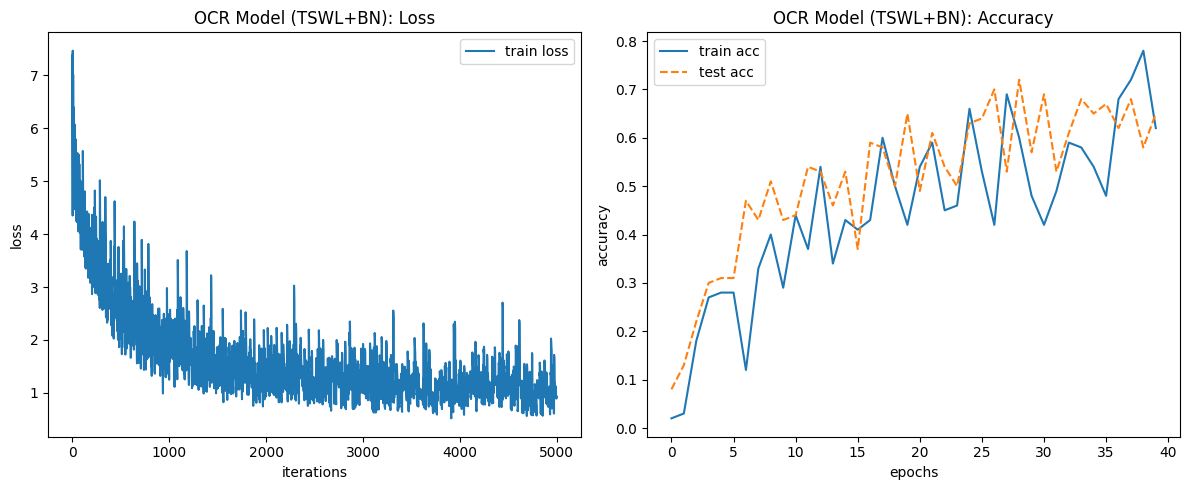

In [ ]:
import os
import sys
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import pickle
import time
from google.colab import drive

import multiprocessing as mp

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/DL_project')

from dataset.ocr_dataset import OCRDataset
from cu_ocr_net_bn2 import OcrNetBN # ✨ TSWL용 BN 모델 임포트
from common.cu_optimizer import Adam

# 데이터 생산자 함수 (기존과 동일)
def data_producer(dataset, queue, batch_size):
    while True:
        x_batch, t_batch = dataset.get_batch(batch_size)
        if x_batch.shape[0] > 0:
            queue.put((x_batch, t_batch))

# ✨ convert_to_length_labels 함수 제거

# 1. 데이터 로드 및 파라미터 설정
print("데이터 로딩 중...")
BASE_PATH = "/content/local_ocr_data"
GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/DL_project"

TRAIN_IMG_PATH = os.path.join(BASE_PATH, "train_images")
TRAIN_LBL_PATH = os.path.join(BASE_PATH, "train_labels")
TEST_IMG_PATH = os.path.join(BASE_PATH, "test_images")
TEST_LBL_PATH = os.path.join(BASE_PATH, "test_labels")
VOCAB_PATH = os.path.join(BASE_PATH, "vocab.json")

IMAGE_WIDTH, IMAGE_HEIGHT = 256, 64
MAX_LABEL_LEN = 16
PAD_ID = 0 # accuracy 계산 시 필요

train_dataset = OCRDataset(TRAIN_IMG_PATH, TRAIN_LBL_PATH, VOCAB_PATH, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), max_label_len=MAX_LABEL_LEN)
test_dataset = OCRDataset(TEST_IMG_PATH, TEST_LBL_PATH, VOCAB_PATH, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), max_label_len=MAX_LABEL_LEN)

# 2. 모델, 옵티마이저 생성
network = OcrNetBN(input_dim=(1, IMAGE_HEIGHT, IMAGE_WIDTH),
                   max_label_len=MAX_LABEL_LEN,
                   vocab_size=train_dataset.vocab_size)
optimizer = Adam(lr=0.001)
base_lr = 0.001
# 3. 학습 하이퍼파라미터 설정
iters_num = 5000
batch_size = 256 # ✨ 배치 크기 원복 (GPU 메모리 확인 필요)
train_size = len(train_dataset.image_files)
iter_per_epoch = max(train_size // batch_size, 1)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 멀티프로세싱 설정
NUM_PRODUCERS = 4 # mp.cpu_count() # ✨ 안정성을 위해 4로 시작 권장
print(f"{NUM_PRODUCERS}개의 생산자 프로세스를 사용합니다.")
data_queue = mp.Queue(maxsize=NUM_PRODUCERS * 5)
producers = []
for _ in range(NUM_PRODUCERS):
    p = mp.Process(target=data_producer,
                   args=(train_dataset, data_queue, batch_size),
                   daemon=True)
    p.start()
    producers.append(p)

data_time = 0
compute_time = 0

print("\n🚀 OCR 모델 학습을 시작합니다 (TSWL + BN, 로컬 I/O)...")
for i in range(iters_num):
    if (i > 0) and (i % 1000 == 0):
      base_lr  = base_lr * 0.5
      optimizer.lr = base_lr  # 옵티마이저의 LR을 직접 갱신
      print(f"\n✨ Iteration {i}: Learning Rate를 {base_lr:.6f}로 조정합니다. ✨\n")

    start_data = time.time()
    x_batch_np, t_text_batch_np = data_queue.get()
    x_batch = cp.asarray(x_batch_np)
    t_text_batch = cp.asarray(t_text_batch_np) # ✨ 글자 내용 레이블 사용!
    data_time += time.time() - start_data

    # ✨ t_len_batch 변환 로직 제거

    start_compute = time.time()
    grad = network.gradient(x_batch, t_text_batch) # ✨ t_text_batch 전달
    optimizer.update(network.params, grad)
    compute_time += time.time() - start_compute

    loss = network.loss(x_batch, t_text_batch) # ✨ t_text_batch 전달
    train_loss_list.append(cp.asnumpy(loss))

    if (i + 1) % 20 == 0:
        avg_data_time = data_time / 20
        avg_compute_time = compute_time / 20
        print(f"Iter: {i+1} / {iters_num} | Loss: {loss.get():.4f} | "
              f"데이터 로딩+전송: {avg_data_time:.3f}초 | 학습 연산: {avg_compute_time:.3f}초")
        data_time, compute_time = 0, 0

    if (i + 1) % iter_per_epoch == 0:
        epoch_num = (i + 1) // iter_per_epoch

        # Train 정확도
        x_train_sample_np, t_train_text_sample_np = train_dataset.get_batch(100)
        x_train_sample = cp.asarray(x_train_sample_np)
        t_train_text_sample = cp.asarray(t_train_text_sample_np)
        # ✨ t_len_sample 변환 제거
        train_acc = network.accuracy(x_train_sample, t_train_text_sample, pad_id=PAD_ID) # ✨ t_text_sample 전달
        train_acc_list.append(cp.asnumpy(train_acc))

        # Test 정확도
        x_test_sample_np, t_test_text_sample_np = test_dataset.get_batch(100)
        x_test_sample = cp.asarray(x_test_sample_np)
        t_test_text_sample = cp.asarray(t_test_text_sample_np)
        # ✨ t_len_sample 변환 제거
        test_acc = network.accuracy(x_test_sample, t_test_text_sample, pad_id=PAD_ID) # ✨ t_text_sample 전달
        test_acc_list.append(cp.asnumpy(test_acc))

        print(f"========== EPOCH {int(epoch_num)} ==========")
        print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
        print("==============================")

for p in producers:
    p.terminate()

# 4. 파라미터 저장
params_file = os.path.join(GDRIVE_PROJECT_PATH, "ocr_params_bn_cupy_local.pkl") # ✨ 파일명 변경
params_cpu = {}
for key, val in network.params.items():
    params_cpu[key] = cp.asnumpy(val)
with open(params_file, 'wb') as f:
    pickle.dump(params_cpu, f)
print(f"\n✅ 학습된 파라미터를 '{params_file}'에 저장했습니다.")

# 5. 그래프 그리기
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train loss')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("OCR Model (TSWL+BN): Loss") # ✨ 제목 변경
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("OCR Model (TSWL+BN): Accuracy") # ✨ 제목 변경
plt.legend()

plt.tight_layout()
plt.show()

Mounted at /content/drive
데이터 로딩 중...
🚀 OCR 데이터셋 초기화를 시작합니다...
✅ 단어장 로드 완료. 총 글자 수: 4109
✅ 총 31535개의 이미지 파일을 처리 대상으로 설정했습니다.
🚀 OCR 데이터셋 초기화를 시작합니다...
✅ 단어장 로드 완료. 총 글자 수: 4109
✅ 총 4000개의 이미지 파일을 처리 대상으로 설정했습니다.
4개의 생산자 프로세스를 사용합니다.

🚀 OCR 모델 학습을 시작합니다 (TSWL + BN, 로컬 I/O)...
Iter: 20 / 10000 | Loss: 4.3966 | 데이터 로딩+전송: 0.054초 | 학습 연산: 0.486초
Iter: 40 / 10000 | Loss: 4.3883 | 데이터 로딩+전송: 0.023초 | 학습 연산: 0.486초
Iter: 60 / 10000 | Loss: 4.0030 | 데이터 로딩+전송: 0.023초 | 학습 연산: 0.485초
Iter: 80 / 10000 | Loss: 4.1336 | 데이터 로딩+전송: 0.023초 | 학습 연산: 0.485초
Iter: 100 / 10000 | Loss: 4.2918 | 데이터 로딩+전송: 0.023초 | 학습 연산: 0.485초
Iter: 120 / 10000 | Loss: 3.8866 | 데이터 로딩+전송: 0.023초 | 학습 연산: 0.485초
========== EPOCH 1 ==========
Train Acc: 0.0600 | Test Acc: 0.0600
Iter: 140 / 10000 | Loss: 3.4985 | 데이터 로딩+전송: 0.023초 | 학습 연산: 0.485초
Iter: 160 / 10000 | Loss: 3.5679 | 데이터 로딩+전송: 0.023초 | 학습 연산: 0.485초
Iter: 180 / 10000 | Loss: 3.4480 | 데이터 로딩+전송: 0.023초 | 학습 연산: 0.485초
Iter: 200 / 10000 | Loss: 4.4468 | 데이터 로딩

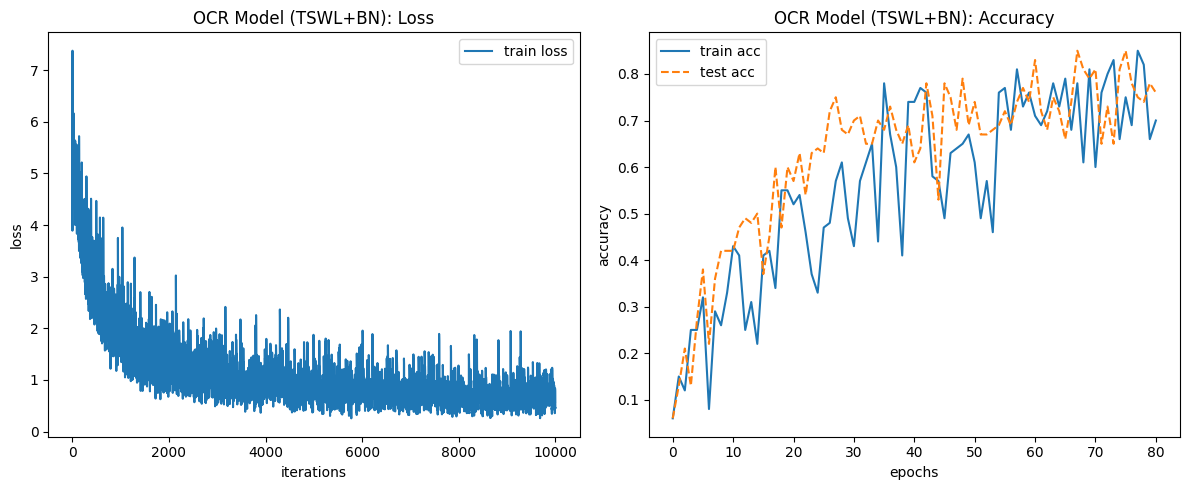

In [20]:
import os
import sys
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import pickle
import time
from google.colab import drive

import multiprocessing as mp

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/DL_project')

from dataset.ocr_dataset import OCRDataset
from cu_ocr_net_bn2 import OcrNetBN # ✨ TSWL용 BN 모델 임포트
from common.cu_optimizer import Adam

# 데이터 생산자 함수 (기존과 동일)
def data_producer(dataset, queue, batch_size):
    while True:
        x_batch, t_batch = dataset.get_batch(batch_size)
        if x_batch.shape[0] > 0:
            queue.put((x_batch, t_batch))

# ✨ convert_to_length_labels 함수 제거

# 1. 데이터 로드 및 파라미터 설정
print("데이터 로딩 중...")
BASE_PATH = "/content/local_ocr_data"
GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/DL_project"

TRAIN_IMG_PATH = os.path.join(BASE_PATH, "train_images")
TRAIN_LBL_PATH = os.path.join(BASE_PATH, "train_labels")
TEST_IMG_PATH = os.path.join(BASE_PATH, "test_images")
TEST_LBL_PATH = os.path.join(BASE_PATH, "test_labels")
VOCAB_PATH = os.path.join(BASE_PATH, "vocab.json")

IMAGE_WIDTH, IMAGE_HEIGHT = 256, 64
MAX_LABEL_LEN = 16
PAD_ID = 0 # accuracy 계산 시 필요

train_dataset = OCRDataset(TRAIN_IMG_PATH, TRAIN_LBL_PATH, VOCAB_PATH, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), max_label_len=MAX_LABEL_LEN)
test_dataset = OCRDataset(TEST_IMG_PATH, TEST_LBL_PATH, VOCAB_PATH, image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), max_label_len=MAX_LABEL_LEN)

# 2. 모델, 옵티마이저 생성
network = OcrNetBN(input_dim=(1, IMAGE_HEIGHT, IMAGE_WIDTH),
                   max_label_len=MAX_LABEL_LEN,
                   vocab_size=train_dataset.vocab_size)
optimizer = Adam(lr=0.001)
base_lr = 0.001
# 3. 학습 하이퍼파라미터 설정
iters_num = 10000
batch_size = 256 # ✨ 배치 크기 원복 (GPU 메모리 확인 필요)
train_size = len(train_dataset.image_files)
iter_per_epoch = max(train_size // batch_size, 1)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 멀티프로세싱 설정
NUM_PRODUCERS = 4 # mp.cpu_count() # ✨ 안정성을 위해 4로 시작 권장
print(f"{NUM_PRODUCERS}개의 생산자 프로세스를 사용합니다.")
data_queue = mp.Queue(maxsize=NUM_PRODUCERS * 5)
producers = []
for _ in range(NUM_PRODUCERS):
    p = mp.Process(target=data_producer,
                   args=(train_dataset, data_queue, batch_size),
                   daemon=True)
    p.start()
    producers.append(p)

data_time = 0
compute_time = 0

print("\n🚀 OCR 모델 학습을 시작합니다 (TSWL + BN, 로컬 I/O)...")
for i in range(iters_num):
    if (i > 0) and (i % 2000 == 0):
      base_lr  = base_lr * 0.5
      optimizer.lr = base_lr  # 옵티마이저의 LR을 직접 갱신
      print(f"\n✨ Iteration {i}: Learning Rate를 {base_lr:.6f}로 조정합니다. ✨\n")

    start_data = time.time()
    x_batch_np, t_text_batch_np = data_queue.get()
    x_batch = cp.asarray(x_batch_np)
    t_text_batch = cp.asarray(t_text_batch_np) # ✨ 글자 내용 레이블 사용!
    data_time += time.time() - start_data

    # ✨ t_len_batch 변환 로직 제거

    start_compute = time.time()
    grad = network.gradient(x_batch, t_text_batch) # ✨ t_text_batch 전달
    optimizer.update(network.params, grad)
    compute_time += time.time() - start_compute

    loss = network.loss(x_batch, t_text_batch) # ✨ t_text_batch 전달
    train_loss_list.append(cp.asnumpy(loss))

    if (i + 1) % 20 == 0:
        avg_data_time = data_time / 20
        avg_compute_time = compute_time / 20
        print(f"Iter: {i+1} / {iters_num} | Loss: {loss.get():.4f} | "
              f"데이터 로딩+전송: {avg_data_time:.3f}초 | 학습 연산: {avg_compute_time:.3f}초")
        data_time, compute_time = 0, 0

    if (i + 1) % iter_per_epoch == 0:
        epoch_num = (i + 1) // iter_per_epoch

        # Train 정확도
        x_train_sample_np, t_train_text_sample_np = train_dataset.get_batch(100)
        x_train_sample = cp.asarray(x_train_sample_np)
        t_train_text_sample = cp.asarray(t_train_text_sample_np)
        # ✨ t_len_sample 변환 제거
        train_acc = network.accuracy(x_train_sample, t_train_text_sample, pad_id=PAD_ID) # ✨ t_text_sample 전달
        train_acc_list.append(cp.asnumpy(train_acc))

        # Test 정확도
        x_test_sample_np, t_test_text_sample_np = test_dataset.get_batch(100)
        x_test_sample = cp.asarray(x_test_sample_np)
        t_test_text_sample = cp.asarray(t_test_text_sample_np)
        # ✨ t_len_sample 변환 제거
        test_acc = network.accuracy(x_test_sample, t_test_text_sample, pad_id=PAD_ID) # ✨ t_text_sample 전달
        test_acc_list.append(cp.asnumpy(test_acc))

        print(f"========== EPOCH {int(epoch_num)} ==========")
        print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
        print("==============================")

for p in producers:
    p.terminate()

# 4. 파라미터 저장
params_file = os.path.join(GDRIVE_PROJECT_PATH, "ocr_params_bn_cupy_local.pkl") # ✨ 파일명 변경
params_cpu = {}
for key, val in network.params.items():
    params_cpu[key] = cp.asnumpy(val)
with open(params_file, 'wb') as f:
    pickle.dump(params_cpu, f)
print(f"\n✅ 학습된 파라미터를 '{params_file}'에 저장했습니다.")

# 5. 그래프 그리기
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train loss')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("OCR Model (TSWL+BN): Loss") # ✨ 제목 변경
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("OCR Model (TSWL+BN): Accuracy") # ✨ 제목 변경
plt.legend()

plt.tight_layout()
plt.show()